pendências
- [x] Procurar sobre importância de atributos
- [x] Calcular acurácia dos modelos
- [x] Fazer previsão por liga

# Imports e carregamentos

In [11]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [12]:
df = pd.read_csv('data_live_engineer_filtered.csv', encoding='utf-8')

In [13]:
df.columns

Index(['minute', 'homeTeam', 'awayTeam', 'shotsHome', 'shotsAway',
       'blockedShotsHome', 'blockedShotsAway', 'league', 'corners_home',
       'corners_away', 'shotsOffgoal_home', 'shotsOffgoal_away',
       'shotsOngoal_home', 'shotsOngoal_away', 'yellowcards_home',
       'yellowcards_away', 'fouls_home', 'fouls_away', 'offsides_home',
       'offsides_away', 'tackles_home', 'tackles_away', 'result', 'match_id',
       'possessiontime_away', 'possessiontime_home', 'shotsOnGoalEfficiency',
       'attackPressure', 'shotAccuracy_home', 'shotAccuracy_away',
       'possessionControl', 'passRisk', 'defensiveDiscipline',
       'defensiveEfficacy', 'defensiveAggression'],
      dtype='object')

## Preprocessamento

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle

# Função para separar os dados em características e variável alvo
def prepare_data(df):
    X = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id'])
    y = df['result']
    print("Dados separados em características (X) e variável alvo (y).")
    return X, y

# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()
    categorical_features = ['league']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ])
    
    print("Preprocessador criado com transformações para características numéricas e categóricas.")
    return preprocessor.fit(X)

# # Preparando os dados
X, y = prepare_data(df)
preprocessor = create_preprocessor(X)
print("Preprocessador ajustado aos dados.")

# Salvando o preprocessador para uso futuro
with open('../models/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)
    print("Preprocessador salvo em '../models/preprocessor.pickle'.")

# Dividindo os dados em conjuntos de treino e teste
X_transformed = preprocessor.transform(X)
print("Dados transformados pelo preprocessador.")

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42, stratify=y)
print("Dados divididos em conjuntos de treino e teste.")

Dados separados em características (X) e variável alvo (y).
Preprocessador criado com transformações para características numéricas e categóricas.
Preprocessador ajustado aos dados.
Preprocessador salvo em '../models/preprocessor.pickle'.
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.


## Rede Neural no Keras: Treinamento e Avaliação 

### Contrução do modelo, salvamento, visualização treino e teste

Epoch 1/500
1203/1203 [==============================] - 9s 6ms/step - loss: 1.0462 - accuracy: 0.5056 - recall: 0.5086 - precision: 0.5056 - auc: 0.5092 - val_loss: 0.8524 - val_accuracy: 0.5277 - val_recall: 0.6117 - val_precision: 0.5237 - val_auc: 0.5352 - lr: 1.0000e-04
Epoch 2/500
1203/1203 [==============================] - 6s 5ms/step - loss: 0.9457 - accuracy: 0.5112 - recall: 0.5154 - precision: 0.5111 - auc: 0.5161 - val_loss: 0.8457 - val_accuracy: 0.5325 - val_recall: 0.5541 - val_precision: 0.5311 - val_auc: 0.5452 - lr: 1.0000e-04
Epoch 3/500
1203/1203 [==============================] - 6s 5ms/step - loss: 0.9051 - accuracy: 0.5112 - recall: 0.5118 - precision: 0.5112 - auc: 0.5152 - val_loss: 0.8406 - val_accuracy: 0.5412 - val_recall: 0.5682 - val_precision: 0.5390 - val_auc: 0.5588 - lr: 1.0000e-04
Epoch 4/500
1203/1203 [==============================] - 5s 5ms/step - loss: 0.8777 - accuracy: 0.5142 - recall: 0.5169 - precision: 0.5141 - auc: 0.5199 - val_loss: 0.8376

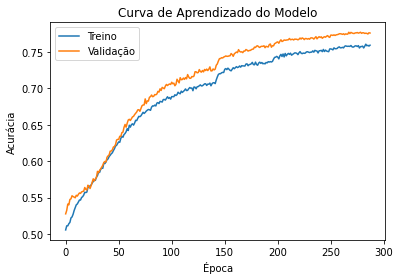

In [28]:
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from keras.regularizers import l2, l1_l2
import tensorflow as tf  # Import the l2 regularizer
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# classes = np.unique(y_train)
# weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
# class_weights = dict(zip(classes, weights))

# Aumentar a complexidade da rede adicionando mais neurônios e camadas
# Construção do modelo
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Aumentar se houver sinais de overfitting
model.add(Dense(1, activation='sigmoid'))

# Otimizador e compilação do modelo
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

# Callbacks para ajuste fino e prevenção de overfitting
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# Treinamento do modelo
history = model.fit(
    X_train, y_train, epochs=500, batch_size=64,
    validation_data=(X_test, y_test),
    # class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Avaliando a acurácia e AUC do modelo
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
train_auc = roc_auc_score(y_train, model.predict(X_train))
test_auc = roc_auc_score(y_test, model.predict(X_test))
print('Acurácia no conjunto de treinamento:', train_acc)
print('Acurácia no conjunto de teste:', test_acc)
print('AUC no conjunto de treinamento:', train_auc)
print('AUC no conjunto de teste:', test_auc)

# Fazendo as predições no conjunto de teste
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0).flatten()  # Converter para 0s e 1s e achatar o array

# Obtendo os rótulos verdadeiros

# Gerando o relatório de classificação
report = classification_report(y_test, predictions, target_names=['Classe 0', 'Classe 1'])

# Imprimindo o relatório de classificação
print("Relatório de Classificação:")
print(report)

# Plotando a curva de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Aprendizado do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

# Salvando o modelo
model.save('../models/model_redeht.h5')

Curva de Aprendizado: A curva de aprendizado mostra que a acurácia de validação e treinamento estão se aproximando uma da outra conforme o número de épocas aumenta, o que é um bom sinal de que o modelo não está sofrendo de overfitting significativo.

Acurácia e AUC: A acurácia e a Área Sob a Curva ROC (AUC) no conjunto de teste são bastante altas, o que sugere que o modelo tem um bom desempenho geral.

Recall e Precision: Os valores de recall e precisão são bastante equilibrados para as previsões no conjunto de validação, indicando que o modelo tem um desempenho bom e equilibrado em relação a ambas as classes.

Relatório de Classificação: O relatório de classificação mostra resultados quase simétricos para as classes 0 e 1, com uma precisão, recall e pontuação F1 bastante semelhantes para ambas, o que sugere que o modelo está tratando ambas as classes de forma equitativa.

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import load_model

# Carregar o modelo
model = load_model('../models/model_redeht.h5')

# Prever as probabilidades para o conjunto de teste
y_probs = model.predict(X_test)

# Inicialize o valor do threshold que você quer testar
thresholds = np.arange(0.1, 0.9, 0.01)

# Para cada threshold, calcule e imprima as métricas
for thresh in thresholds:
    # Converta probabilidades em previsões binárias com base no threshold
    y_pred = (y_probs >= thresh).astype(int)
    
    # Calcule as métricas para a classe 1
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Imprima as métricas
    print(f'Threshold: {thresh:.2f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}, Accuracy: {accuracy:.3f}')

# Escolha o threshold que oferece o melhor equilíbrio entre as métricas que são importantes para o seu caso de uso


602/602 [==============================] - 1s 1ms/step
Threshold: 0.10, Precision: 0.552, Recall: 0.998, F1 Score: 0.711, Accuracy: 0.594
Threshold: 0.11, Precision: 0.557, Recall: 0.997, F1 Score: 0.715, Accuracy: 0.602
Threshold: 0.12, Precision: 0.562, Recall: 0.996, F1 Score: 0.718, Accuracy: 0.609
Threshold: 0.13, Precision: 0.566, Recall: 0.995, F1 Score: 0.722, Accuracy: 0.616
Threshold: 0.14, Precision: 0.571, Recall: 0.993, F1 Score: 0.725, Accuracy: 0.624
Threshold: 0.15, Precision: 0.575, Recall: 0.992, F1 Score: 0.728, Accuracy: 0.630
Threshold: 0.16, Precision: 0.580, Recall: 0.990, F1 Score: 0.732, Accuracy: 0.637
Threshold: 0.17, Precision: 0.585, Recall: 0.989, F1 Score: 0.735, Accuracy: 0.643
Threshold: 0.18, Precision: 0.589, Recall: 0.988, F1 Score: 0.738, Accuracy: 0.650
Threshold: 0.19, Precision: 0.594, Recall: 0.987, F1 Score: 0.742, Accuracy: 0.657
Threshold: 0.20, Precision: 0.599, Recall: 0.985, F1 Score: 0.745, Accuracy: 0.663
Threshold: 0.21, Precision: 0.60

## Visualizando características importantes

In [26]:
# from keras.models import load_model
# model = load_model('../models/model_redeht_final.h5')

# import shap
# # Criando o explainer
# explainer = shap.DeepExplainer(model, X_train)
# # Subconjunto do conjunto de teste para análise
# X_test_sample = X_test[:200]  # Ajuste o tamanho da amostra conforme necessário

# # Calculando os valores SHAP
# shap_values = explainer.shap_values(X_test_sample)
# # Plotando um gráfico de resumo
# # shap.summary_plot(shap_values, X_test_sample)

# # Obter os nomes das colunas numéricas
# numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()

# # Obter os nomes das colunas após a transformação
# # Para as características numéricas, permanecem os mesmos
# transformed_numeric_features = numeric_features

# # Como só tem uma característica categórica:
# categories = preprocessor.named_transformers_['cat'].categories_
# transformed_categorical_features = [
#     f'league_{category}' for category in categories[0][1:]  # drop='first' remove a primeira categoria
# ]

# # Combina os dois
# all_transformed_features = transformed_numeric_features + transformed_categorical_features

In [27]:
# # Plotando um gráfico de resumo com nomes de features reais
# shap.summary_plot(shap_values, features=X_test_sample, feature_names=all_transformed_features, max_display=X_test_sample.shape[1])